<a href="https://colab.research.google.com/github/GiulioCMSanto/HDSIdent/blob/master/notebooks/MIMO%20Systems/Potential%20Intervals/mimo_ewma_potential_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potential Intervals for Multivariable Sytems: Exponentially Weighted Moving Average (EWMA)

[HDSIdent: Historical Data Segmentation for System Identification](https://github.com/GiulioCMSanto/HDSIdent)

This notebook explores how to obtain potential intervals for system identification considering multivariables systems. The Exponentially Weighted Moving Average (EWMA) filter is the approache considered in this notebook



**NOTICE: this notebook, as well as the related dataset, is part of my masters dissertation, which was not yet published. Therefore, referencing is not permited until the work is available.**


_**Related works**_:

```
PERETZKI, D. et al. Data mining of historic data for process identification.
In: Proceedings of the 2011 AIChE Annual Meeting, p. 1027–1033, 2011.

SHARDT, Y. A. W.; SHAH, S. L. Segmentation Methods for Model Identification from
Historical Process Data. In: Proceedings of the 19th World Congress.
Cape Town, South Africa: IFAC, 2014. p. 2836–2841.

BITTENCOURT, A. C. et al. An algorithm for finding process identification
intervals from normal operating data. Processes, v. 3, p. 357–383, 2015.

PATEL, A. Data Mining of Process Data in Mutlivariable Systems.
Degree project in electrical engineering — Royal Institute of Technology,
Stockholm, Sweden, 2016.

ARENGAS, D.; KROLL, A. A Search Method for Selecting Informative Data in Predominantly
Stationary Historical Records for Multivariable System Identification.
In: Proceedings of the 21st International Conference on System Theory,
Control and Computing (ICSTCC). Sinaia, Romenia: IEEE, 2017a. p. 100–105.

ARENGAS, D.; KROLL, A. Searching for informative intervals in predominantly stationary
data records to support system identification. In: Proceedings of the XXVI International
Conference on Information, Communication and Automation Technologies (ICAT). Sarajevo,
Bosnia-Herzegovina: IEEE, 2017b.

WANG, J. et al. Searching historical data segments for process
identification in feedback control loops. Computers and Chemical
Engineering, v. 112, n. 6, p. 6–16, 2018.
```




In [1]:
!git clone https://github.com/GiulioCMSanto/HDSIdent.git

Cloning into 'HDSIdent'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 697 (delta 87), reused 109 (delta 36), pack-reused 491
Receiving objects: 100% (697/697), 7.14 MiB | 5.22 MiB/s, done.
Resolving deltas: 100% (319/319), done.


In [2]:
# Change into the directory for install
%cd HDSIdent/

/content/HDSIdent


In [3]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating HDSIdent.egg-info
writing HDSIdent.egg-info/PKG-INFO
writing dependency_links to HDSIdent.egg-info/dependency_links.txt
writing requirements to HDSIdent.egg-info/requires.txt
writing top-level names to HDSIdent.egg-info/top_level.txt
writing manifest file 'HDSIdent.egg-info/SOURCES.txt'
writing manifest file 'HDSIdent.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/HDSIdent
copying HDSIdent/__init__.py -> build/lib/HDSIdent
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/HDSIdent
copying build/lib/HDSIdent/__init__.py -> build/bdist.linux-x86_64/egg/HDSIdent
byte-compiling build/bdist.linux-x86_64/egg/HDSIdent/__init__.py to __init__.cpython-36.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying HDSIdent.egg-info/PKG-INFO -> build/bdist.linu

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

plotly.io.renderers.default = 'colab'

%matplotlib inline
sns.set_style('darkgrid')

In [6]:
from HDSIdent.data_treatment.data_preprocessing import Preprocessing
from HDSIdent.initial_intervals.exponentially_weighted import ExponentiallyWeighted
from HDSIdent.initial_intervals.bandpass_filter import BandpassFilter
from HDSIdent.initial_intervals.non_parametric_pettitt import PettittMethod

## **1. Read Data**

In [7]:
u1_url = "https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/distillation_column/mimo_simu_u1.csv"
u2_url = "https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/distillation_column/mimo_simu_u2.csv"
y1_url = "https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/distillation_column/mimo_simu_y1.csv"
y2_url = "https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/distillation_column/mimo_simu_y2.csv"

In [8]:
u1 = pd.read_csv(u1_url, error_bad_lines=False, header=None)
u2 = pd.read_csv(u2_url, error_bad_lines=False, header=None)
y1 = pd.read_csv(y1_url, error_bad_lines=False, header=None)
y2 = pd.read_csv(y2_url, error_bad_lines=False, header=None)

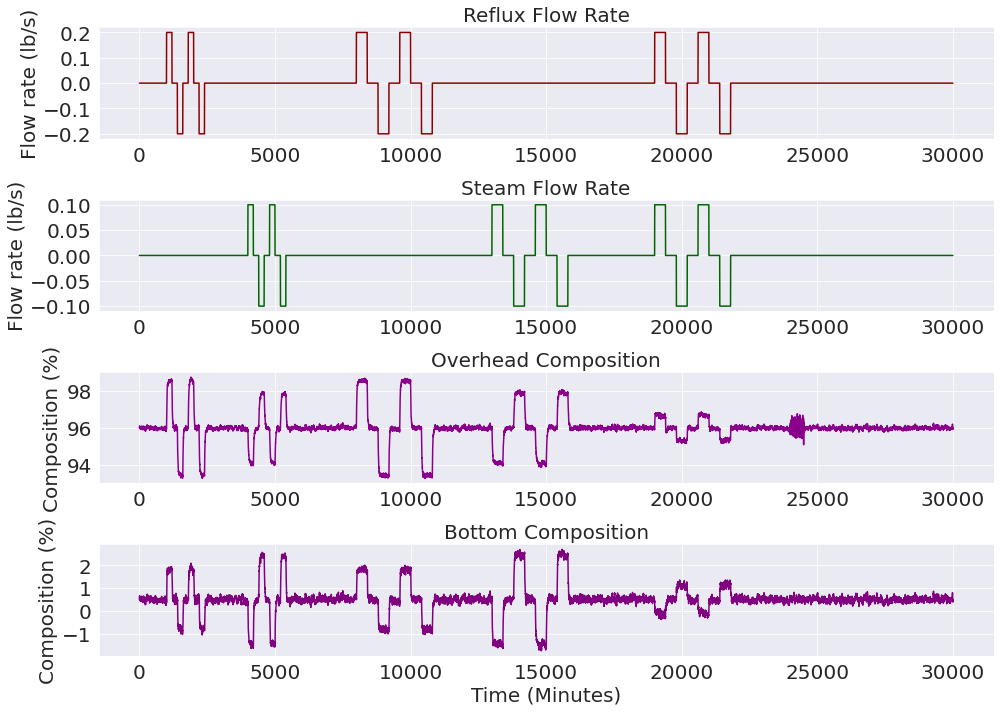

In [11]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.plot(u1, color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,2);
plt.plot(u2, color='darkgreen');
plt.title("Steam Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,3);
plt.plot(y1, color='darkmagenta');
plt.title("Overhead Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,4);
plt.plot(y2,  color='purple');
plt.title("Bottom Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xlabel("Time (Minutes)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.tight_layout();

## **2. Data Preprocessing**

In [9]:
pp = Preprocessing(
        scaler='MinMaxScaler',
        feature_range=(-0.5,0.5),
        k=100);

In [10]:
X_clean, Y_clean = pp.fit_transform(X=np.concatenate([u1,u2],axis=1),
                                    y=np.concatenate([y1,y2],axis=1))

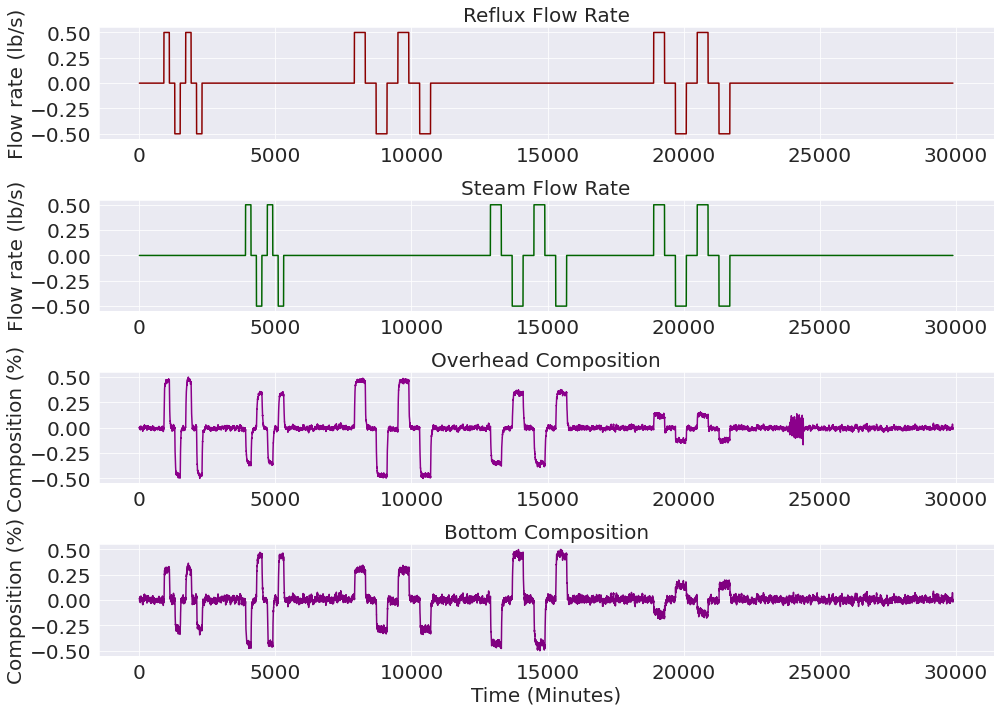

In [12]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.plot(X_clean[:,0], color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,2);
plt.plot(X_clean[:,1], color='darkgreen');
plt.title("Steam Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,3);
plt.plot(Y_clean[:,0], color='darkmagenta');
plt.title("Overhead Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.subplot(4,1,4);
plt.plot(Y_clean[:,1],  color='purple');
plt.title("Bottom Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xlabel("Time (Minutes)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

plt.tight_layout();

## **3. Potential Intervals**

### **3.1 Exponentially Weighted Moving Average (EWMA) Filter**

**Pontential intervals are found considering the Set-point and the Output Variable**

In [13]:
df = pd.DataFrame()
df['U1'] = np.squeeze(X_clean[:,0])
df['U2'] = np.squeeze(X_clean[:,1])
df['Y1'] = np.squeeze(Y_clean[:,0])
df['Y2'] = np.squeeze(Y_clean[:,1])

In [14]:
df.head()

,U1,U2,Y1,Y2
0,0.0,0.0,0.003292,0.016390
1,0.0,0.0,0.002377,0.014547
2,0.0,0.0,0.004389,0.018323
3,0.0,0.0,-0.000914,0.008537
4,0.0,0.0,-0.004389,0.002412


In [15]:
EW = ExponentiallyWeighted(
        forgetting_fact_v = np.array([0.006,0.006,0.006,0.006]),
        forgetting_fact_u = np.array([0.006,0.006,0.006,0.006]),
        H_v = [0.005,0.005,0.005,0.005],
        num_previous_indexes=0,
        verbose=0,
        n_jobs=-1);

In [16]:
start = time()
EW.fit(X=df[['U1','U2']], y=df[['Y1','Y2']]);
end = time()

In [17]:
print("Execution Time: {}".format(end-start))

Execution Time: 20.20244288444519


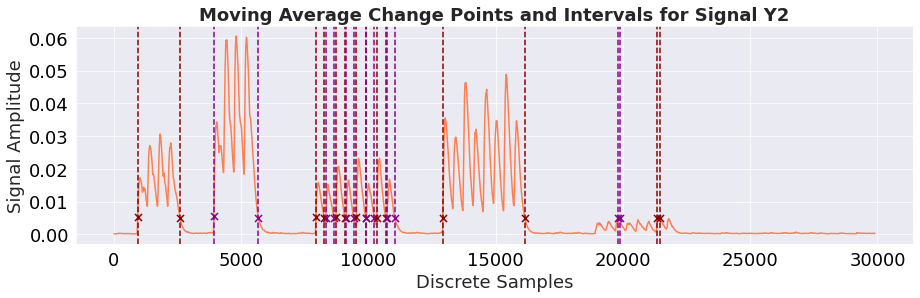

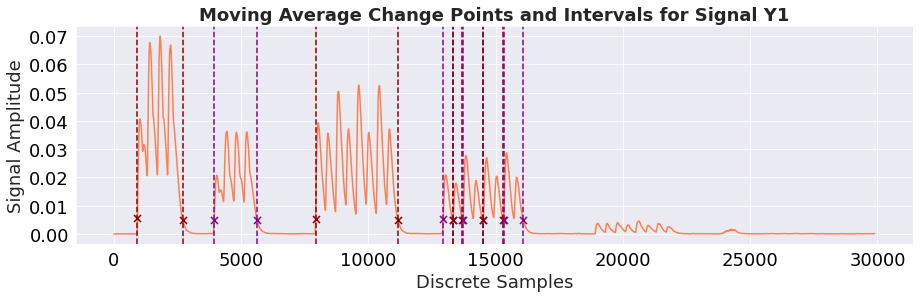

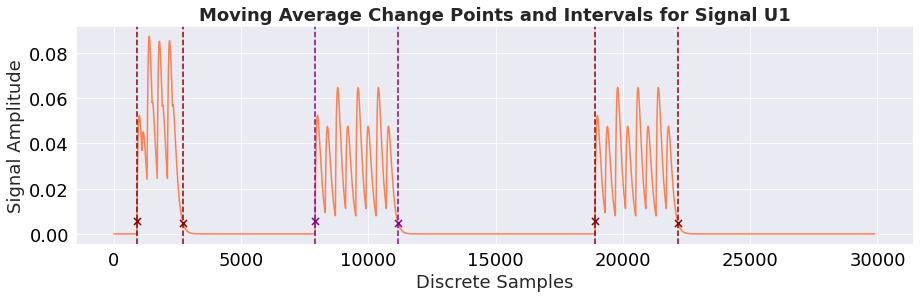

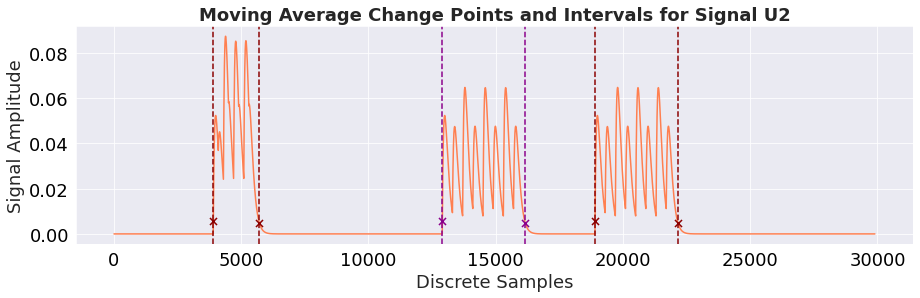

In [18]:
EW.plot_change_points(X=df[['U1','U2']], y=df[['Y1','Y2']])

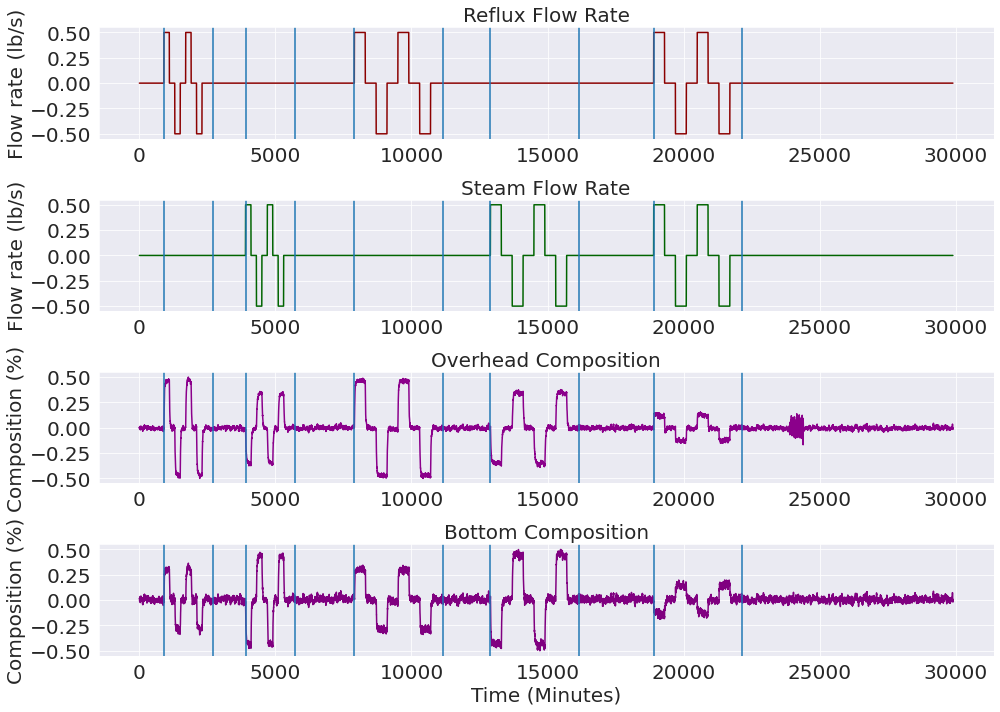

In [19]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.plot(X_clean[:,0], color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.subplot(4,1,2);
plt.plot(X_clean[:,1], color='darkgreen');
plt.title("Steam Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.subplot(4,1,3);
plt.plot(Y_clean[:,0], color='darkmagenta');
plt.title("Overhead Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.subplot(4,1,4);
plt.plot(Y_clean[:,1],  color='purple');
plt.title("Bottom Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xlabel("Time (Minutes)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.tight_layout();

### **3.1.1 Effect of the Filter in Step Responses**

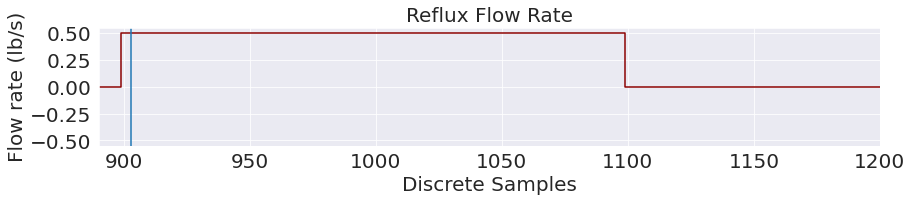

In [20]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.step(range(0,len(X_clean[:,0])),X_clean[:,0], color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xlabel("Discrete Samples", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
plt.xlim([890,1200]);

#### **3.1.1.1 Including Previous Indexes**

In [21]:
EW = ExponentiallyWeighted(
        forgetting_fact_v = np.array([0.006,0.006,0.006,0.006]),
        forgetting_fact_u = np.array([0.006,0.006,0.006,0.006]),
        H_v = [0.005,0.005,0.005,0.005],
        num_previous_indexes=50,
        verbose=0,
        n_jobs=-1);
        
EW.fit(X=df[['U1','U2']], y=df[['Y1','Y2']]);

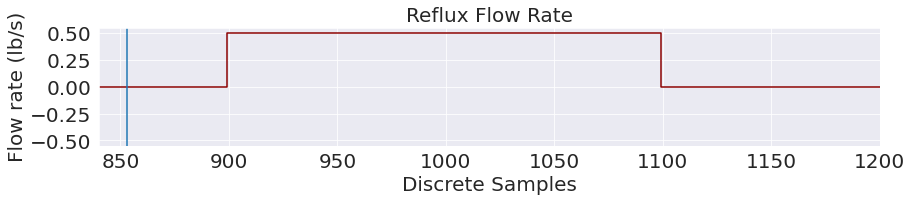

In [22]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.step(range(0,len(X_clean[:,0])),X_clean[:,0], color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xlabel("Discrete Samples", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
plt.xlim([840,1200]);